In [2]:
!pip install tensorflow

In [3]:
import numpy as np
import pandas as pd
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
import time

In [4]:
sdir=r'/content/drive/MyDrive/DeepLearning_UniversityProject/DATA'
filepaths = []
labels=[]
classlist=sorted(os.listdir(sdir) )
for klass in classlist:
    classpath=os.path.join(sdir, klass)
    flist=os.listdir(classpath)
    for f in flist:
        fpath=os.path.join(classpath,f)
        filepaths.append(fpath)
        labels.append(klass)
Fseries=pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')
df=pd.concat([Fseries, Lseries], axis=1)


In [5]:
train_df, dummy_df=train_test_split(df, train_size=.6, shuffle=True, random_state=123, stratify=df['labels'])
valid_df, test_df=train_test_split(dummy_df, train_size=.5, shuffle=True, random_state=123, stratify=dummy_df['labels'])
print('train_df lenght: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))

train_df lenght:  96   test_df length:  32   valid_df length:  32


In [6]:
# Lấy số lượng lớp và số lượng ảnh cho mỗi lớp trong train_df
classes = sorted(list(train_df['labels'].unique()))
class_count = len(classes)
print('Số lượng lớp trong bộ dữ liệu là: ', class_count)

groups = train_df.groupby('labels')
print('{0:^30s} {1:^13s}'.format('LỚP', 'SỐ LƯỢNG ẢNH'))
countlist = []
classlist = []

for label in sorted(list(train_df['labels'].unique())):
    group = groups.get_group(label)
    countlist.append(len(group))
    classlist.append(label)
    print('{0:^30s} {1:^13s}'.format(label, str(len(group))))

# Lấy lớp có số lượng ảnh nhiều nhất và ít nhất
max_value = np.max(countlist)
max_index = countlist.index(max_value)
max_class = classlist[max_index]

min_value = np.min(countlist)
min_index = countlist.index(min_value)
min_class = classlist[min_index]

print(max_class, ' có nhiều ảnh nhất= ', max_value, ' ', min_class, ' có ít ảnh nhất= ', min_value)

# Lấy chiều cao và chiều rộng trung bình của một mẫu ảnh trong tập train
ht = 0
wt = 0

# Chọn ngẫu nhiên 100 mẫu từ train_df
train_df_sample = train_df.sample(n=90, random_state=123, axis=0)

for i in range(len(train_df_sample)):
    fpath = train_df_sample['filepaths'].iloc[i]
    img = plt.imread(fpath)
    shape = img.shape
    ht += shape[0]
    wt += shape[1]

print('Chiều cao trung bình= ', ht // 100, ' Chiều rộng trung bình= ', wt // 100, ' Tỷ lệ khung hình= ', ht / wt)

Số lượng lớp trong bộ dữ liệu là:  5
             LỚP               SỐ LƯỢNG ẢNH 
            Chair                   19      
            Clock                   20      
             Desk                   19      
            Laptop                  19      
            People                  19      
Clock  có nhiều ảnh nhất=  20   Chair  có ít ảnh nhất=  19
Chiều cao trung bình=  382  Chiều rộng trung bình=  441  Tỷ lệ khung hình=  0.867849696310398


In [7]:
def trim(df, max_samples, min_samples, column):
    # Tạo bản sao của DataFrame để không thay đổi DataFrame gốc
    df = df.copy()

    # Nhóm DataFrame theo cột chỉ định
    groups = df.groupby(column)

    # Tạo DataFrame mới để lưu trữ dữ liệu đã được cắt giảm
    trimmed_df = pd.DataFrame(columns=df.columns)

    # Lặp qua từng nhóm
    for label in df[column].unique():
        group = groups.get_group(label)
        count = len(group)

        # Nếu số lượng mẫu lớn hơn max_samples, giữ ngẫu nhiên max_samples mẫu
        if count > max_samples:
            sampled_group = group.sample(n=max_samples, random_state=123, axis=0)
            trimmed_df = pd.concat([trimmed_df, sampled_group], axis=0)
        else:
            # Nếu số lượng mẫu nằm trong khoảng [min_samples, max_samples], giữ toàn bộ nhóm
            if min_samples <= count <= max_samples:
                sampled_group = group
                trimmed_df = pd.concat([trimmed_df, sampled_group], axis=0)

    print('Sau khi cắt giảm, số lượng mẫu tối đa trong mỗi lớp hiện đang là ', max_samples, ' và số lượng mẫu tối thiểu trong mỗi lớp là ', min_samples)

    return trimmed_df

max_samples = 150  # Vì mỗi lớp có hơn 200 ảnh, tất cả các lớp sẽ được cắt giảm xuống còn 200 ảnh mỗi lớp
min_samples = 15
column = 'labels'
train_df = trim(train_df, max_samples, min_samples, column)

Sau khi cắt giảm, số lượng mẫu tối đa trong mỗi lớp hiện đang là  150  và số lượng mẫu tối thiểu trong mỗi lớp là  15


In [8]:
def balance(df, n, working_dir, img_size):
    # Tạo bản sao của DataFrame để không thay đổi DataFrame gốc
    df = df.copy()

    print('Độ dài ban đầu của dataframe là ', len(df))

    # Tạo đường dẫn cho thư mục chứa ảnh được tăng cường
    aug_dir = os.path.join(working_dir, 'aug')

    # Nếu thư mục tồn tại, xóa thư mục để bắt đầu với thư mục trống
    if os.path.isdir(aug_dir):
        shutil.rmtree(aug_dir)

    # Tạo thư mục mới để chứa ảnh được tăng cường
    os.mkdir(aug_dir)

    # Tạo thư mục cho mỗi lớp
    for label in df['labels'].unique():
        dir_path = os.path.join(aug_dir, label)
        os.mkdir(dir_path)

    # Tạo và lưu trữ ảnh được tăng cường
    total = 0
    gen = ImageDataGenerator(
        horizontal_flip=True,
        rotation_range=20,
        width_shift_range=.2,
        height_shift_range=.2,
        zoom_range=.2
    )

    groups = df.groupby('labels')  # Nhóm theo lớp
    for label in df['labels'].unique():
        group = groups.get_group(label)
        sample_count = len(group)

        # Nếu số lượng mẫu ít hơn n (số lượng mẫu mục tiêu)
        if sample_count < n:
            aug_img_count = 0
            delta = n - sample_count

            # Định rõ thư mục đích để lưu ảnh
            target_dir = os.path.join(aug_dir, label)

            # In thông điệp về quá trình tăng cường
            msg = '{0:40s} cho lớp {1:^30s} tạo {2:^5s} ảnh được tăng cường'.format(' ', label, str(delta))
            print(msg, '\r', end='')  # In trên cùng một dòng

            # Tạo generator cho ảnh được tăng cường
            aug_gen = gen.flow_from_dataframe(
                group,
                x_col='filepaths',
                y_col=None,
                target_size=img_size,
                class_mode=None,
                batch_size=1,
                shuffle=False,
                save_to_dir=target_dir,
                save_prefix='aug-',
                color_mode='rgb',
                save_format='jpg'
            )

            # Tăng cường đến khi đạt được số lượng mong muốn
            while aug_img_count < delta:
                images = next(aug_gen)
                aug_img_count += len(images)

            total += aug_img_count

    print('Tổng số ảnh được tăng cường= ', total)

    # Tạo DataFrame mới từ ảnh tăng cường và ghép nó với DataFrame ban đầu để tạo tập dữ liệu huấn luyện kết hợp
    aug_fpaths = []
    aug_labels = []

    classlist = os.listdir(aug_dir)
    for klass in classlist:
        classpath = os.path.join(aug_dir, klass)
        flist = os.listdir(classpath)
        for f in flist:
            fpath = os.path.join(classpath, f)
            aug_fpaths.append(fpath)
            aug_labels.append(klass)

    Fseries = pd.Series(aug_fpaths, name='filepaths')
    Lseries = pd.Series(aug_labels, name='labels')

    aug_df = pd.concat([Fseries, Lseries], axis=1)
    df = pd.concat([df, aug_df], axis=0).reset_index(drop=True)

    print('Độ dài của dataframe sau khi tăng cường là ', len(df))

    return df

n = 150  # Số lượng mẫu trong mỗi lớp
working_dir = r'./'  # Thư mục để lưu ảnh được tăng cường
img_size = (150, 150)  # Kích thước của ảnh được tăng cường
train_df = balance(train_df, n, working_dir, img_size)

Độ dài ban đầu của dataframe là  96
Found 19 validated image filenames.
Found 19 validated image filenames.
Found 20 validated image filenames.
Found 19 validated image filenames.
Found 19 validated image filenames.
Tổng số ảnh được tăng cường=  654
Độ dài của dataframe sau khi tăng cường là  750


In [9]:
batch_size = 30  # Sử dụng mô hình EfficientetB3, với kích thước ảnh (200, 250), kích thước này không gây lỗi tài nguyên
trgen = ImageDataGenerator(
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=.2,
    height_shift_range=.2,
    zoom_range=.2
)
t_and_v_gen = ImageDataGenerator()

msg = '{0:70s} cho bộ tạo ảnh huấn luyện'.format(' ')
print(msg, '\r', end='')  # In trên cùng một dòng
train_gen = trgen.flow_from_dataframe(
    train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

msg = '{0:70s} cho bộ tạo ảnh xác thực'.format(' ')
print(msg, '\r', end='')  # In trên cùng một dòng
valid_gen = t_and_v_gen.flow_from_dataframe(
    valid_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)

# Đối với test_gen, chúng ta muốn tính toán batch size và test steps sao cho
# batch_size x test_steps = số lượng mẫu trong tập test
# Điều này đảm bảo rằng chúng ta sẽ duyệt qua tất cả các mẫu trong tập test đúng một lần.
length = len(test_df)
test_batch_size = sorted([int(length/n) for n in range(1, length+1) if length % n == 0 and length/n <= 80], reverse=True)[0]
test_steps = int(length/test_batch_size)

msg = '{0:70s} cho bộ tạo ảnh kiểm thử'.format(' ')
print(msg, '\r', end='')  # In trên cùng một dòng
test_gen = t_and_v_gen.flow_from_dataframe(
    test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=test_batch_size
)

# Từ generator, chúng ta có thể lấy thông tin chúng ta sẽ cần sử dụng sau này
classes = list(train_gen.class_indices.keys())
class_indices = list(train_gen.class_indices.values())
class_count = len(classes)
labels = test_gen.labels
print('Kích thước batch kiểm thử: ', test_batch_size, '  số bước kiểm thử: ', test_steps, ' số lớp: ', class_count)

Found 750 validated image filenames belonging to 5 classes.
Found 32 validated image filenames belonging to 5 classes.
Found 32 validated image filenames belonging to 5 classes.
Kích thước batch kiểm thử:  32   số bước kiểm thử:  1  số lớp:  5


In [10]:
def show_image_samples(gen):
    t_dict = gen.class_indices
    classes = list(t_dict.keys())

    # Lấy một lô mẫu từ generator
    images, labels = next(gen)

    plt.figure(figsize=(20, 20))

    # Xác định số lượng ảnh tối đa để hiển thị (tối đa 25 ảnh)
    length = len(labels)
    if length < 25:
        r = length
    else:
        r = 25

    for i in range(r):
        plt.subplot(5, 5, i + 1)

        # Chuẩn hóa ảnh về khoảng [0, 1]
        image = images[i] / 255

        plt.imshow(image)

        # Lấy chỉ số lớp có xác suất cao nhất
        index = np.argmax(labels[i])
        class_name = classes[index]

        plt.title(class_name, color='blue', fontsize=14)
        plt.axis('off')

    plt.show()

show_image_samples(train_gen)

Output hidden; open in https://colab.research.google.com to view.

In [11]:
img_shape = (img_size[0], img_size[1], 3)
model_name = 'EfficientNetB3'

# Tạo mô hình cơ bản EfficientNetB3
base_model = tf.keras.applications.efficientnet.EfficientNetB3(
    include_top=False,
    weights="imagenet",
    input_shape=img_shape,
    pooling='max'
)

base_model.trainable = True

x = base_model.output
x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
x = Dense(
    256,
    kernel_regularizer=regularizers.l2(l=0.016),
    activity_regularizer=regularizers.l1(0.006),
    bias_regularizer=regularizers.l1(0.006),
    activation='relu'
)(x)
x = Dropout(rate=0.4, seed=123)(x)
output = Dense(class_count, activation='softmax')(x)

# Tạo mô hình tổng cùng với mô hình cơ bản
model = Model(inputs=base_model.input, outputs=output)

lr = 0.001  # Bắt đầu với tỷ lệ học này
model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

43941136/43941136 [==============================] - 0s 0us/step


In [12]:
class LR_ASK(tf.keras.callbacks.Callback):
    def __init__(self, model, epochs, ask_epoch):
        super(LR_ASK, self).__init__()
        self.model = model
        self.ask_epoch = ask_epoch
        self.epochs = epochs
        self.ask = True  # Nếu True, hỏi người dùng ở một epoch cụ thể
        self.lowest_vloss = float('inf')
        self.best_weights = self.model.get_weights()  # Đặt trọng số tốt nhất về trọng số ban đầu của mô hình
        self.best_epoch = 1

    def on_train_begin(self, logs=None):
        if self.ask_epoch == 0:
            print('Bạn đã đặt ask_epoch = 0, ask_epoch sẽ được đặt lại là 1', flush=True)
            self.ask_epoch = 1
        if self.ask_epoch >= self.epochs:
            print('ask_epoch >= epochs, sẽ huấn luyện cho ', self.epochs, ' epochs', flush=True)
            self.ask = False
        if self.epochs == 1:
            self.ask = False
        else:
            print('Huấn luyện sẽ tiếp tục đến epoch', self.ask_epoch, ' sau đó bạn sẽ được hỏi để')
            print(' nhập H để dừng huấn luyện hoặc nhập một số nguyên cho số epoch tiếp theo rồi lại hỏi')
        self.start_time = time.time()

    def on_train_end(self, logs=None):
        print('Đang tải mô hình với trọng số từ epoch ', self.best_epoch)
        self.model.set_weights(self.best_weights)
        tr_duration = time.time() - self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'Thời gian huấn luyện là {str(hours)} giờ, {minutes:4.1f} phút, {seconds:4.2f} giây)'
        print(msg, flush=True)

    def on_epoch_end(self, epoch, logs=None):
        v_loss = logs.get('val_loss')
        if v_loss < self.lowest_vloss:
            self.lowest_vloss = v_loss
            self.best_weights = self.model.get_weights()
            self.best_epoch = epoch + 1
            print(f'\n Loss xác thực của {v_loss:7.4f} thấp hơn loss thấp nhất, lưu trọng số từ epoch {str(epoch + 1):3s} làm trọng số tốt nhất')
        else:
            print(f'\n Loss xác thực của {v_loss:7.4f} cao hơn loss thấp nhất {self.lowest_vloss:7.4f}, giữ nguyên trọng số từ epoch {str(self.best_epoch)} làm trọng số tốt nhất')

        if self.ask:
            if epoch + 1 == self.ask_epoch:
                print('\n Nhập H để dừng huấn luyện hoặc một số nguyên cho số epoch bổ sung để chạy và hỏi lại')
                ans = input()

                if ans.lower() == 'h' or ans == '0':
                    print(f'Bạn đã nhập {ans}, Huấn luyện dừng lại ở epoch {epoch+1} do đầu vào của người dùng\n', flush=True)
                    self.model.stop_training = True
                else:
                    self.ask_epoch += int(ans)
                    if self.ask_epoch > self.epochs:
                        print(f'\nBạn đã chỉ định số epochs tối đa là {self.epochs}, không thể huấn luyện thêm {self.ask_epoch}', flush=True)
                    else:
                        print(f'Bạn đã nhập {ans}, Huấn luyện sẽ tiếp tục đến epoch {self.ask_epoch}', flush=True)
                        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))
                        print(f'Tỉ lệ học hiện tại là {lr:7.5f}, nhấn enter để giữ nguyên tỉ lệ này hoặc nhập một tỉ lệ học mới')
                        ans = input(' ')
                        if ans == '':
                            print(f'Giữ nguyên tỉ lệ học hiện tại của {lr:7.5f}')
                        else:
                            new_lr = float(ans)
                            tf.keras.backend.set_value(self.model.optimizer.lr, new_lr)
                            print(' Thay đổi tỉ lệ học thành ', ans)

In [13]:
epochs=10
ask_epoch=5
ask=LR_ASK(model, epochs,  ask_epoch)
rlronp=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2,verbose=1)
callbacks=ask

In [ ]:
history = model.fit(x=train_gen, epochs=epochs, callbacks=callbacks, validation_data=valid_gen)

Huấn luyện sẽ tiếp tục đến epoch 5  sau đó bạn sẽ được hỏi để
 nhập H để dừng huấn luyện hoặc nhập một số nguyên cho số epoch tiếp theo rồi lại hỏi
Epoch 1/10
25/25 [==============================] - ETA: 0s - loss: 8.0079 - accuracy: 0.8440
 Loss xác thực của  7.7110 thấp hơn loss thấp nhất, lưu trọng số từ epoch 1   làm trọng số tốt nhất
25/25 [==============================] - 83s 807ms/step - loss: 8.0079 - accuracy: 0.8440 - val_loss: 7.7110 - val_accuracy: 0.9375
Epoch 2/10
25/25 [==============================] - ETA: 0s - loss: 6.9302 - accuracy: 0.9773
 Loss xác thực của  6.7083 thấp hơn loss thấp nhất, lưu trọng số từ epoch 2   làm trọng số tốt nhất
25/25 [==============================] - 9s 357ms/step - loss: 6.9302 - accuracy: 0.9773 - val_loss: 6.7083 - val_accuracy: 0.9688
Epoch 3/10
25/25 [==============================] - ETA: 0s - loss: 6.2178 - accuracy: 0.9800
 Loss xác thực của  5.9915 thấp hơn loss thấp nhất, lưu trọng số từ epoch 3   làm trọng số tốt nhất
25/25 [

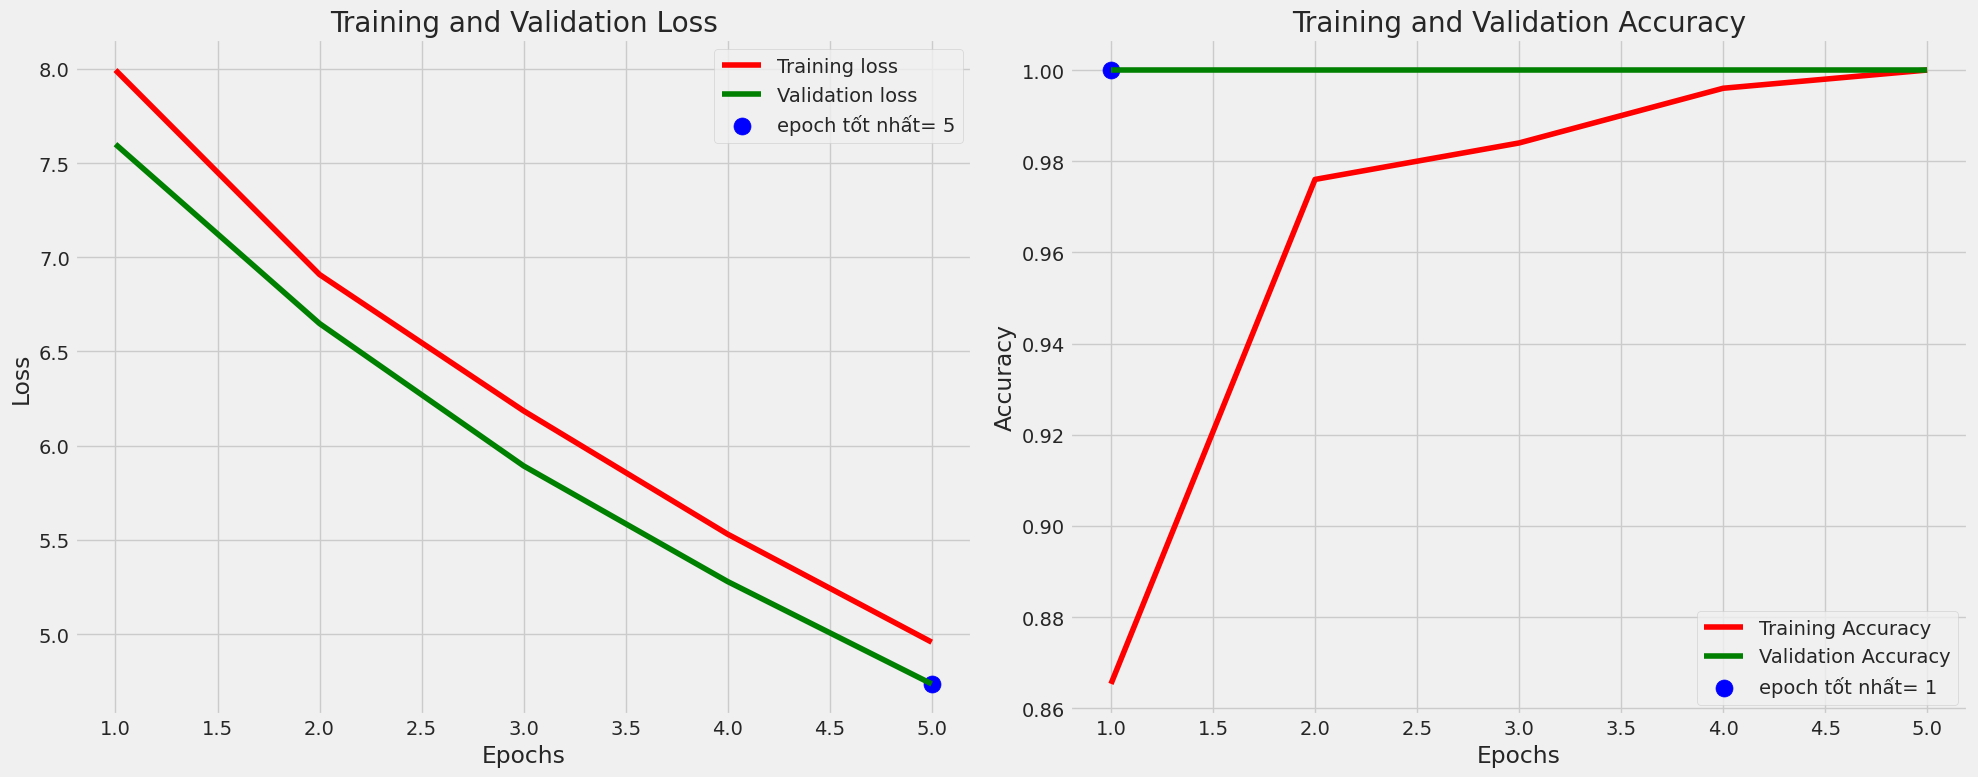

In [ ]:
def tr_plot(tr_data, start_epoch):
    # Vẽ dữ liệu huấn luyện và xác thực
    tacc = tr_data.history['accuracy']
    tloss = tr_data.history['loss']
    vacc = tr_data.history['val_accuracy']
    vloss = tr_data.history['val_loss']
    Epoch_count = len(tacc) + start_epoch
    Epochs = [i + 1 for i in range(start_epoch, Epoch_count)]
    index_loss = np.argmin(vloss)  # đây là epoch có validation loss thấp nhất
    val_lowest = vloss[index_loss]
    index_acc = np.argmax(vacc)
    acc_highest = vacc[index_acc]

    # Thiết lập kiểu plot
    plt.style.use('fivethirtyeight')
    sc_label = 'epoch tốt nhất= ' + str(index_loss + 1 + start_epoch)
    vc_label = 'epoch tốt nhất= ' + str(index_acc + 1 + start_epoch)

    # Tạo subplot
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

    # Plot cho Loss
    axes[0].plot(Epochs, tloss, 'r', label='Training loss')
    axes[0].plot(Epochs, vloss, 'g', label='Validation loss')
    axes[0].scatter(index_loss + 1 + start_epoch, val_lowest, s=150, c='blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    # Plot cho Accuracy
    axes[1].plot(Epochs, tacc, 'r', label='Training Accuracy')
    axes[1].plot(Epochs, vacc, 'g', label='Validation Accuracy')
    axes[1].scatter(index_acc + 1 + start_epoch, acc_highest, s=150, c='blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()

    # Hiển thị biểu đồ
    plt.tight_layout()
    plt.show()

# Truyền vào lịch sử huấn luyện (`history`) và epoch bắt đầu (`0`)
tr_plot(history, 0)

In [ ]:
history = model.fit(x=train_gen, epochs=epochs, callbacks=callbacks, validation_data=valid_gen)

Huấn luyện sẽ tiếp tục đến epoch 5  sau đó bạn sẽ được hỏi để
 nhập H để dừng huấn luyện hoặc nhập một số nguyên cho số epoch tiếp theo rồi lại hỏi
Epoch 1/10
25/25 [==============================] - ETA: 0s - loss: 4.4468 - accuracy: 0.9947
 Loss xác thực của  4.2857 thấp hơn loss thấp nhất, lưu trọng số từ epoch 1   làm trọng số tốt nhất
25/25 [==============================] - 9s 334ms/step - loss: 4.4468 - accuracy: 0.9947 - val_loss: 4.2857 - val_accuracy: 1.0000
Epoch 2/10
25/25 [==============================] - ETA: 0s - loss: 3.9741 - accuracy: 0.9973
 Loss xác thực của  3.8395 thấp hơn loss thấp nhất, lưu trọng số từ epoch 2   làm trọng số tốt nhất
25/25 [==============================] - 8s 302ms/step - loss: 3.9741 - accuracy: 0.9973 - val_loss: 3.8395 - val_accuracy: 1.0000
Epoch 3/10
25/25 [==============================] - ETA: 0s - loss: 3.5949 - accuracy: 0.9973
 Loss xác thực của  3.4759 thấp hơn loss thấp nhất, lưu trọng số từ epoch 3   làm trọng số tốt nhất
25/25 [=

1/1 [==============================] - 4s 4s/step
there were 0 errors in 32 tests for an accuracy of 100.00


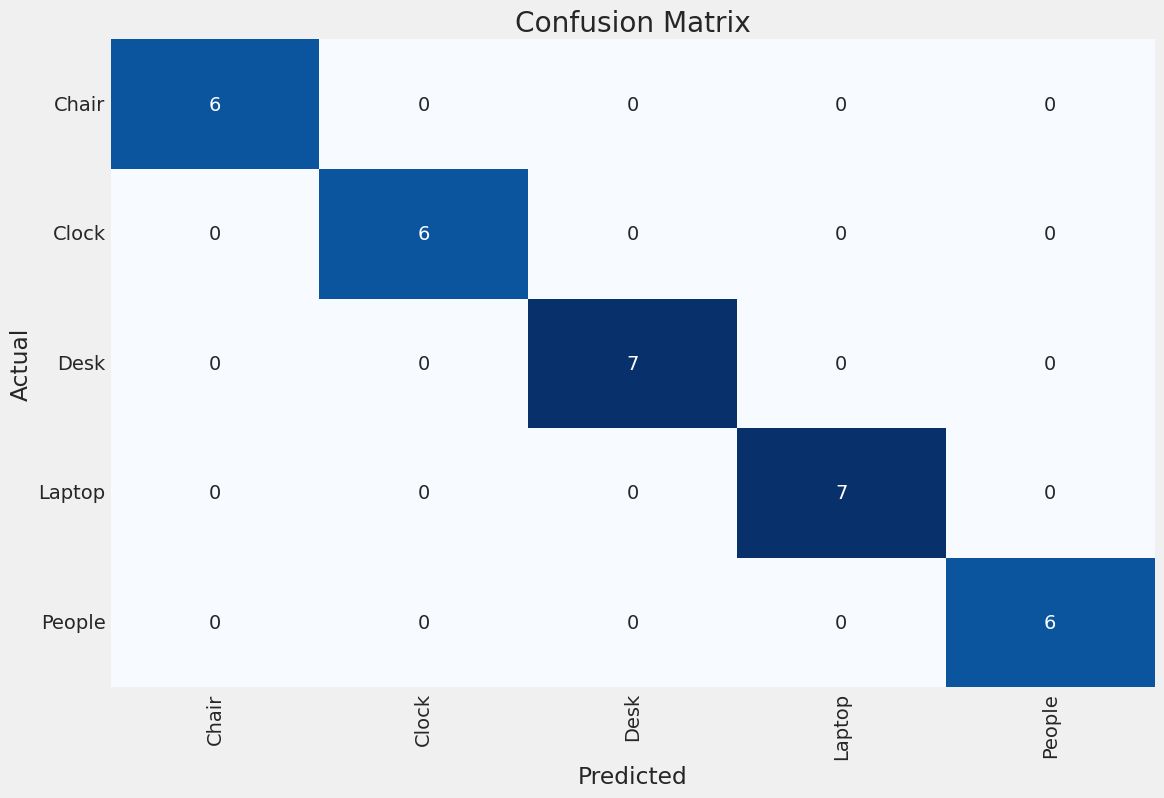

Classification Report:
----------------------
               precision    recall  f1-score   support

       Chair     1.0000    1.0000    1.0000         6
       Clock     1.0000    1.0000    1.0000         6
        Desk     1.0000    1.0000    1.0000         7
      Laptop     1.0000    1.0000    1.0000         7
      People     1.0000    1.0000    1.0000         6

    accuracy                         1.0000        32
   macro avg     1.0000    1.0000    1.0000        32
weighted avg     1.0000    1.0000    1.0000        32



In [ ]:
def predictor(test_gen, test_steps):
    y_pred= []
    y_true=test_gen.labels
    classes=list(test_gen.class_indices.keys())
    class_count=len(classes)
    errors=0
    preds=model.predict(test_gen, verbose=1)
    tests=len(preds)
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)
        true_index=test_gen.labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            errors=errors + 1
            file=test_gen.filenames[i]
        y_pred.append(pred_index)

    acc=( 1-errors/tests) * 100
    print(f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}')
    ypred=np.array(y_pred)
    ytrue=np.array(y_true)
    if class_count <=30:
        cm = confusion_matrix(ytrue, ypred )
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
        plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
    print("Classification Report:\n----------------------\n", clr)
    return errors, tests
errors, tests=predictor(test_gen, test_steps)

In [ ]:
subject='cnn'
acc=str(( 1-errors/tests) * 100)
index=acc.rfind('.')
acc=acc[:index + 3]
save_id= subject + '_' + 'model'+ '.h5'
model_save_loc=os.path.join(working_dir, save_id)
model.save(model_save_loc)
print ('model was saved as ' , model_save_loc )

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


model was saved as  ./cnn_model.h5


In [ ]:
!pip install -q streamlit
!npm install localtunnel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 66.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.1 MB/s eta 0:00:00
npm WARN saveError ENOENT: no such file or directory, open '/content/package.json'
npm notice created a lockfile as package-lock.json. You should commit this file.
npm WARN enoent ENOENT: no such file or directory, open '/content/package.json'
npm WARN content No description
npm WARN content No repository field.
npm WARN content No README data
npm WARN content No license field.

+ localtunnel@2.0.2
added 22 packages from 22 contributors and audited 22 packages in 1.655s

3 packages are looking for funding
  run `npm fund` for details

found 1 moderate severity vulnerability
  run `npm audit 

In [ ]:
!streamlit run /content/drive/MyDrive/CNN_NBBQUOC/streamlit.py &>/content/logs.txt &

In [ ]:
!npx localtunnel --port 8501

npx: installed 22 in 2.097s
your url is: https://blue-shrimps-notice.loca.lt
